In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helper import *
import matplotlib.dates as mdates
import pandas as pd
from sklearn import preprocessing

In [2]:
def dropcol(df,cols):
    return df.drop(cols, axis = 1, inplace = True)

# we convert dates to datetime format
def to_datetime(data, cols):
    for col in cols:
        data[col] = pd.to_datetime(data[col])

def extract_hour(df):
    df['HORA'] = df['Fecha-I'].hour 

def periodo_dia(df):
    extract_hour(df)
    if (df['HORA'] >= 5) and (df['HORA'] < 12):
        return 'mañana'
    elif  (df['HORA'] >=12) and  (df['HORA'] < 19):
        return 'tarde'
    elif  (df['HORA'] >=19) or  (df['HORA'] < 5):
        return 'noche'

def addcol_periodo_dia(df):
    df['periodo_dia'] = df.apply(lambda x: periodo_dia(x), axis = 1)

def analisis_atraso_por_col(df,col):
    # % de vuelos atrasados por col
    col_atraso = df.groupby([col])['atraso_15'].value_counts(normalize=True)
    col_atraso = col_atraso.groupby([col]).apply(lambda x: x.iloc[0]).reset_index().sort_values(by = 'atraso_15')
    col_atraso.rename(columns = {'atraso_15':'%_no_atrasados'}, inplace=True)
    col_atraso['atraso_15']= 1-col_atraso['%_no_atrasados']
    # % de vuelos operados por cada col 
    column_df = df[col].value_counts(normalize=True).reset_index()
    column_df.rename(columns = {f'{col}':'%_de_total_vuelos'}, inplace=True)
    column_df[f'%_atrasados_por_{col}'] = col_atraso['atraso_15']
    atraso_total = (df.groupby(col)['atraso_15'].sum()/len(df[df['atraso_15']==1])).reset_index()
    column_df = pd.merge(atraso_total, column_df, left_on = [col], right_on= ['index'], how = 'left')
    column_df.rename(columns = {'atraso_15':'%_atrasados_de_total_atrasados'}, inplace=True)
    column_df = column_df.sort_values('%_de_total_vuelos', ascending = False)
    column_df['cumsum_total_vuelos'] = column_df['%_de_total_vuelos'].cumsum()
    column_df['cumsum_atrasados'] = column_df['%_atrasados_de_total_atrasados'].cumsum()
    dropcol(column_df,['index'])
    return column_df 

def DummyCol(df,columnsToEncode):
    df = pd.get_dummies(df,columns = columnsToEncode, drop_first=False)
    return df

In [3]:
#  C:\Users\rebeccah.cohen\AppData\Local\Programs\Python\Python310\python.exe -m pip install pandas
data = pd.read_csv('Challenge_LATAM/dataset_SCL.csv', low_memory=False)

In [4]:
print(f'El dataset tiene {len(data)} vuelos') 

El dataset tiene 68206 vuelos


##### Data Cleaning & Adding Columns

In [5]:
data.head(2)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


In [7]:
# Pasamos a datetime las fechas
datecols = ['Fecha-O', 'Fecha-I']
to_datetime(data, datecols)

In [8]:
# crear las nuevas columnas 
df = data.copy()
df['dif_min'] = (df['Fecha-O']-df['Fecha-I']).dt.total_seconds()/60
df['atraso_15'] = np.where(df['dif_min'] > 15, 1, 0)
high_season = df.loc[((df['Fecha-I'] >= "2017-12-15") & (df['Fecha-I'] < '2018-03-04')) |
                     ((df['Fecha-I'] >= "2017-07-15") & (df['Fecha-I'] < '2017-08-01')) |
                     ((df['Fecha-I'] >= "2017-09-11") & (df['Fecha-I'] < '2018-10-01'))]
df['temporada_alta'] = df['Fecha-I'].isin(high_season['Fecha-I']).astype(int)
addcol_periodo_dia(df)

In [9]:
# guardar df como synthetic_features.csv
df.to_csv("Challenge_LATAM/synthetic_features.csv")

Hacemos drop a las columnas `Ori-I`, `Ori-O` y `SIGLAORI` ya que no tienen valores distintos.
Eliminamos también la columna `AÑO` ya que tenemos solamente 2 valores del año 2018. El resto de los valores son todos del año 2017.

In [10]:
print(df['Ori-I'].value_counts())
print(df['Ori-O'].value_counts())
print(df['SIGLAORI'].value_counts())
print(df['AÑO'].value_counts())


SCEL    68206
Name: Ori-I, dtype: int64
SCEL    68206
Name: Ori-O, dtype: int64
Santiago    68206
Name: SIGLAORI, dtype: int64
2017    68204
2018        2
Name: AÑO, dtype: int64


In [11]:
dropcol(df,['Ori-I', 'Ori-O', 'SIGLAORI', 'AÑO'])

In [12]:
datecols = ['Fecha-O', 'Fecha-I']
to_datetime(df, datecols)

Hacemos drop a las columna referente a las Fechas ya que hemos sacado la información relevante de ellas. 

In [13]:
dropcol(df, ['Fecha-I', 'Fecha-O'])

## Preguntas 1 y 3

#### Target Variables 


##### atraso_15

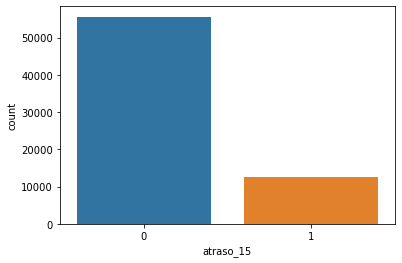

0    0.81506
1    0.18494
Name: atraso_15, dtype: float64

In [14]:
# comprobamos cuantos vuelos atrasados vs no atrasados tenemos
sns.countplot(x='atraso_15', data=df)
plt.rcParams["figure.figsize"] = (4, 4)
plt.show()
df['atraso_15'].value_counts(normalize = True)

Casi un 18,5% de los vuelos se atrasaron más de 15 minutos. Es un dataset no balanceado.  

##### dif_min - Diferencia de minutos

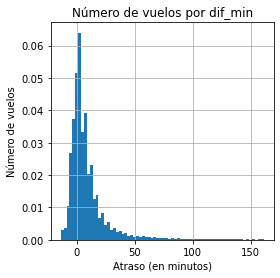

In [15]:
df['dif_min'].hist(bins=70, density=True)
plt.rcParams["figure.figsize"] = (8,8)
plt.ylabel('Número de vuelos')
plt.xlabel('Atraso (en minutos)')
plt.title('Número de vuelos por dif_min')
plt.show()

Observamos una distribución de dif_min que está sesgada a la derecha. La distribución está centrada en 0 - cosa que tiene sentido, ya que la mayoría de vuelos no sufren atraso. 
También vemos vuelos que se adelantan (valores negativos en dif_min), pero hay mayor cantidad de vuelos que se atrasan que vuelos que se adelantan (right-skewed distribution).

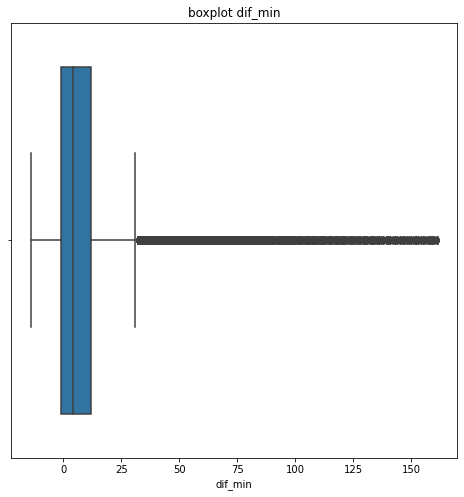

In [16]:
ax = sns.boxplot(x=df['dif_min'])
plt.title('boxplot dif_min')
plt.show()

In [17]:
q3, q1 = np.percentile(df['dif_min'],[75, 25])
IQR = q3 - q1
print(f'El IQR es de {IQR} minutos')


El IQR es de 13.0 minutos


In [18]:
df['dif_min'].describe()

count    68206.000000
mean         9.110855
std         19.313387
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64

El 75% de los vuelos se atrasa un máximo de 12 minutos. El promedio de minutos de atraso es de 9 minutos. 

La mayoría de vuelos no sufren un atraso considerable, ya que según la definición de atraso_15, un vuelo se considera atrasado cuando se atrasó más de 15 minutos. 

Aún así, vemos una larga cola a la derecha en la distribución de datos, viendo vuelos que se atrasan 60 o más minutos. 

#### Predictor Variables

##### Aerolinea Programada vs Aerolinea Actual

Creamos la columna 'cambio_aerolinea' para verificar si hubo un cambio en la aerolinea (programada vs actual)

Las columnas 'Emp-O' y 'OPERA' expresan lo mismo - la Aerolinea o Grupo Comercial de Aerolineas que llevan a cabo el vuelo.
Es por ello que decidimos hacer drop a 'Emp-O'

In [19]:
df['cambio_aerolinea'] = np.where(df['Emp-I'] == df['Emp-O'], 0, 1)
dropcol(df, ['Emp-O'])

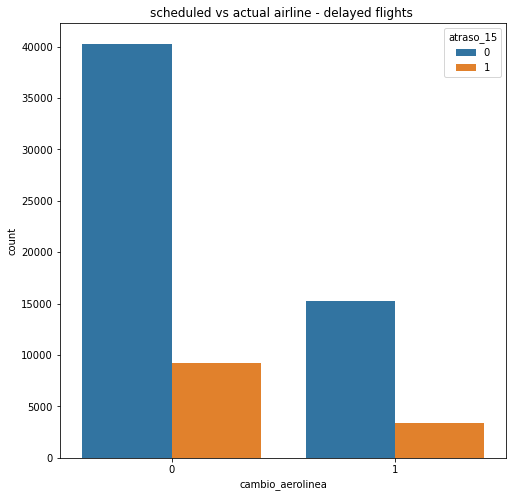

In [20]:
# check if scheduled airline is the same as actual airline 
sns.countplot(x = 'cambio_aerolinea', hue='atraso_15', data=df)
plt.title('scheduled vs actual airline - delayed flights ')
plt.rcParams["figure.figsize"] = (3, 3)
plt.show()

In [21]:
analisis_atraso_por_col(df,'cambio_aerolinea')

,cambio_aerolinea,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_cambio_aerolinea,cumsum_total_vuelos,cumsum_atrasados
0,0,0.73355,0.726285,0.186790,0.726285,0.73355
1,1,0.26645,0.273715,0.180031,1.000000,1.00000


Observamos que la aerolinea actual no es siempre la misma que la aerolinea programada.
Esto podría ser un indicador de atraso de vuelos.
Un 26,6 % del total de vuelos atrasados sufrieron un cambio en la aerolinea. 
En cuanto al total de vuelos, un 72,62% de ellos no sufrieron cambio en la aerolinea. 
Tanto de los vuelos que sufrieron cambio en aerolinea como los que no, un 18% aproximadamente de los vuelos se atrasaron más de 15 minutos. 

##### Numero de vuelo programado vs Numero de vuelo actual

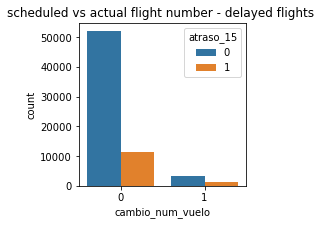

In [22]:
df['cambio_num_vuelo'] = np.where(df['Vlo-I'] == df['Vlo-O'], 0, 1)
sns.countplot(x = 'cambio_num_vuelo', hue='atraso_15', data=df)
plt.title('scheduled vs actual flight number - delayed flights ')
plt.rcParams["figure.figsize"] = (5, 5)
plt.show()

In [23]:
analisis_atraso_por_col(df,'cambio_num_vuelo')

,cambio_num_vuelo,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_cambio_num_vuelo,cumsum_total_vuelos,cumsum_atrasados
0,0,0.908435,0.933745,0.179927,0.933745,0.908435
1,1,0.091565,0.066255,0.255588,1.000000,1.000000


In [24]:
analisis_atraso_por_col(df,'Vlo-I').head(10)

,Vlo-I,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_Vlo-I,cumsum_total_vuelos,cumsum_atrasados
184,174,0.007135,0.010058,0.142506,0.010058,0.007135
29,11,0.002378,0.009457,0.230769,0.019514,0.009513
69,116,0.018472,0.008914,0.200000,0.028429,0.027985
164,150,0.006342,0.008166,0.333333,0.036595,0.034327
446,704,0.012764,0.008152,0.000000,0.044747,0.047091
175,162,0.004360,0.008108,0.000000,0.052855,0.051451
176,164,0.006580,0.008064,0.333333,0.060918,0.058031
78,118,0.002061,0.007448,0.081633,0.068366,0.060092
183,172,0.006421,0.007301,0.000000,0.075668,0.066513
180,170,0.003250,0.007257,0.437500,0.082925,0.069764


In [25]:
analisis_atraso_por_col(df,'Vlo-O').head()

,Vlo-O,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_Vlo-O,cumsum_total_vuelos,cumsum_atrasados
257,174,0.006025,0.009515,0.143216,0.009515,0.006025
36,11,0.002378,0.009471,0.111111,0.018987,0.008403
87,116,0.018472,0.008914,0.240000,0.027901,0.026875
225,150,0.005708,0.007580,0.214286,0.035481,0.032583
686,704,0.011257,0.007536,0.200000,0.043017,0.043840


Solamente un 2.7% del total de vuelos sufrieron un cambio en el número de vuelos. 
De los vuelos atrasados, un 3.7% sufrieron un cambio en el número de vuelo. 
Con estos datos presentes y analizando los vuelos atrasados por las columnas 'Vol-I' y 'Vol-O' (número de vuelo programado, número de vuelo de operación de vuelo), parece que el número de vuelo no tiene una gran influencia en el atraso del vuelo. Decidimos, por lo tanto, hacer drop a estas columnas


In [26]:
dropcol(df,['Vlo-O', 'Vlo-I'])

##### Destino programado vs Destino final

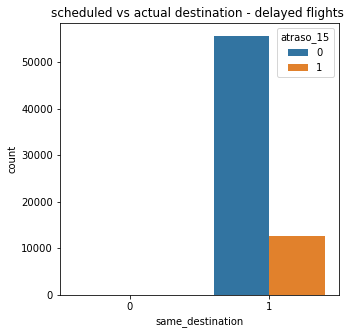

In [27]:
# comprobamos si el destino programado es igual al destino del vuelo. 
df['same_destination'] = np.where(df['Des-I'] == df['Des-O'], 1, 0)
sns.countplot(x = 'same_destination', hue='atraso_15', data=df)
plt.title('scheduled vs actual destination - delayed flights ')
plt.show()

Observamos que el destino actual es siempre igual al destino programado (columnas 'Des-I' y 'Des-O')
Es decir, no hay cambios en los destinos de los vuelos para todo el dataset. 
Hacemos drop de la columna 'Des-I'

In [28]:
dropcol(df,['Des-I'])

##### TIPOVUELO: Vuelos Nacionales vs Vuelos Internacionales

<AxesSubplot:xlabel='count', ylabel='TIPOVUELO'>

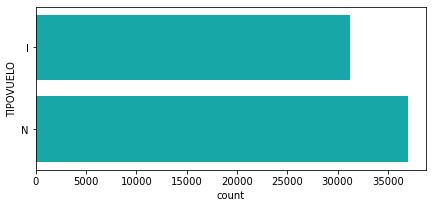

In [29]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="TIPOVUELO", data=df, color="c")

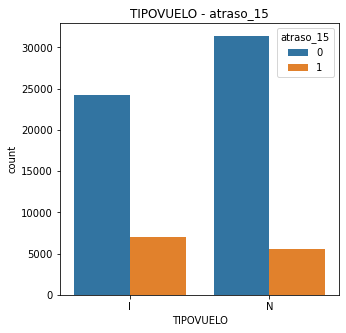

In [30]:
sns.countplot(x = 'TIPOVUELO', hue='atraso_15', data=df)
plt.title('TIPOVUELO - atraso_15')
plt.show()


In [31]:
analisis_atraso_por_col(df,'TIPOVUELO')

,TIPOVUELO,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_TIPOVUELO,cumsum_total_vuelos,cumsum_atrasados
1,N,0.441256,0.541976,0.225608,0.541976,0.441256
0,I,0.558744,0.458024,0.150571,1.000000,1.000000


Observamos que un 22% de vuelos internacionales se atrasan vs un 15% de vuelos nacionales. 
Algunas de las razones por las que los vuelos internacionales se atrasen más que los nacionales pueden ser: medidas de seguridad por operar con distintos países, mayor tiempo de mantenimiento al avión (por ser vuelos más largos), condiciones climáticas de distintos paises, etc.

En total un 54% de los vuelos son vuelos nacionales y un 45.8% son internacionales. 

##### TEMPORADA_ALTA 

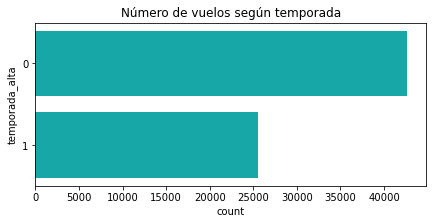

In [32]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="temporada_alta", data=df, color="c")
plt.title('Número de vuelos según temporada')
plt.show()

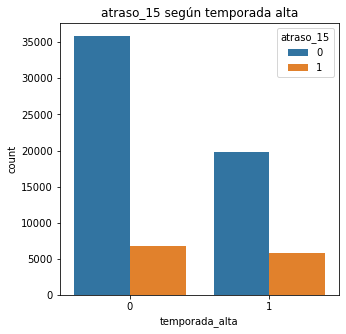

In [33]:
# Vuelos atrasados según temporada
sns.countplot(x = 'temporada_alta', hue='atraso_15', data=df)
plt.title('atraso_15 según temporada alta')
plt.show()

In [34]:
analisis_atraso_por_col(df, 'temporada_alta')

,temporada_alta,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_temporada_alta,cumsum_total_vuelos,cumsum_atrasados
0,0,0.541541,0.625883,0.160018,0.625883,0.541541
1,1,0.458459,0.374117,0.226633,1.000000,1.000000


En temporada alta un 22,66 % de los vuelos se atrasan, vs un 16 % de los vuelos cuando no es temporada alta. 
El 37.41% de los vuelos son en temporada alta. 

##### DÍA

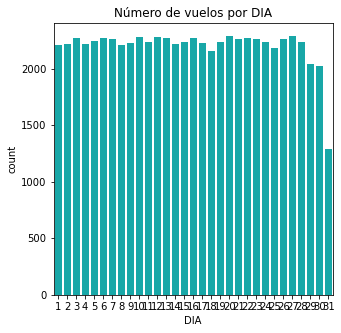

In [35]:
sns.countplot(x="DIA", data=df, color = 'c')
plt.title('Número de vuelos por DIA')
plt.show()

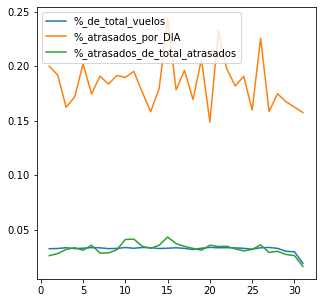

In [36]:
dia = analisis_atraso_por_col(df,'DIA').sort_index()
fig, ax = plt.subplots()

ax.plot('DIA', '%_de_total_vuelos', data= dia, label = '%_de_total_vuelos')
ax.plot('DIA', '%_atrasados_por_DIA', data= dia, label = '%_atrasados_por_DIA')
ax.plot('DIA', '%_atrasados_de_total_atrasados', data= dia, label = '%_atrasados_de_total_atrasados')
ax.legend(loc='upper left')
plt.show()

El número de vuelos por DIA se distribuye más o menos de manera uniforme, pero observamos que al final del mes el número de vuelos es menor. Esto puede ser debido a que las personas a fin de mes estén más ajustados con el presupuesto y viajen menos. 

En cuanto a vuelos atrasados por DIA del mes, podemos ver que a principio y a final de mes hay menos vuelos atrasados, y en promedio los vuelos se atrasan más la segunda y tercera semana del mes. 

Debido a que ya incluimos la variable DIANOM, vamos a hacer drop a esta variable .

In [37]:
dropcol(df, ['DIA'])

##### MES

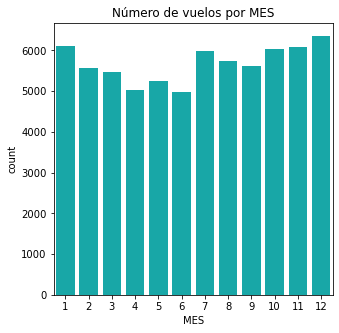

In [38]:
sns.countplot(x="MES", data=df, color = 'c')
plt.title("Número de vuelos por MES")
plt.show()

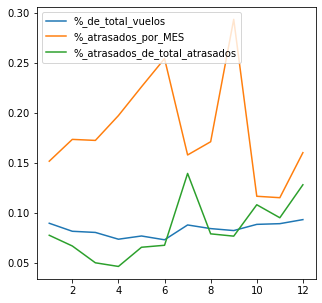

In [39]:
mes = analisis_atraso_por_col(df,'MES').sort_index()
fig, ax = plt.subplots()

ax.plot('MES', '%_de_total_vuelos', data= mes, label = '%_de_total_vuelos')
ax.plot('MES', '%_atrasados_por_MES', data= mes, label = '%_atrasados_por_MES')
ax.plot('MES', '%_atrasados_de_total_atrasados', data= mes, label = '%_atrasados_de_total_atrasados')
ax.legend(loc='upper left')
plt.show()

In [40]:
mes.loc[mes['MES'].isin([6,9])]

,MES,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_MES,cumsum_total_vuelos,cumsum_atrasados
5,6,0.067544,0.073029,0.254091,1.000000,1.000000
8,9,0.076661,0.082251,0.293391,0.614638,0.703663


El número de vuelos por MES se distribuye de manera casi-uniforme en todos los meses. Observamos un aumento en cantidad de vuelos los meses de JULIO, DICIEMBRE y ENERO. Esto tiene sentido, ya que son meses de temporada_alta y, en estos meses la gente tiende a viajar más - las vacaciones escolares, las fiestas de navidad, etc son razones por las cuales la gente decide viajar más esos meses. 

En cuanto a % de los vuelos atrasados por MES, vemos un aumento en los meses de Junio y Septiembre, con un 25,40% de vuelos atrasados en Junio y un 29.33% en Septiembre. 

##### DIANOM

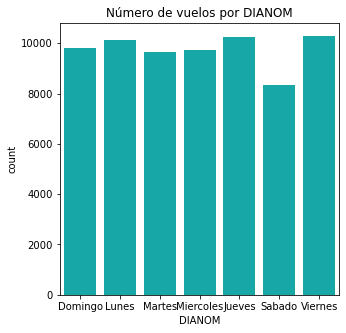

In [41]:
sns.countplot(x="DIANOM", data=df, color = 'c')
plt.title("Número de vuelos por DIANOM")
plt.show()

In [42]:
dianom = analisis_atraso_por_col(df,'DIANOM')
dianom

,DIANOM,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_DIANOM,cumsum_total_vuelos,cumsum_atrasados
6,Viernes,0.181148,0.150896,0.161086,0.150896,0.181148
1,Jueves,0.162121,0.150295,0.199493,0.301191,0.343269
2,Lunes,0.162359,0.148535,0.202152,0.449726,0.505629
0,Domingo,0.125099,0.143624,0.169116,0.593350,0.630728
4,Miercoles,0.131679,0.142539,0.170850,0.735888,0.762407
3,Martes,0.129539,0.141659,0.163194,0.877547,0.891945
5,Sabado,0.108055,0.122453,0.222017,1.000000,1.000000


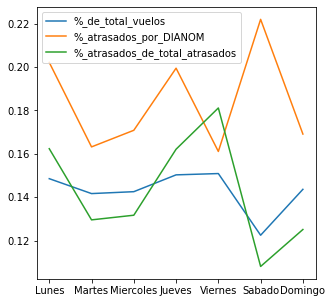

In [43]:

dianom = analisis_atraso_por_col(df,'DIANOM')
days = {'Lunes':0,'Martes':1,'Miercoles':2,'Jueves':3,'Viernes':4,'Sabado':5,'Domingo':6}
dianom['DIANOM'] = dianom['DIANOM'].apply(lambda x: days[x])
dianom = dianom.sort_values('DIANOM')
days = {0:'Lunes',1:'Martes',2:'Miercoles',3:'Jueves',4:'Viernes',5:'Sabado',6:'Domingo'}
dianom['DIANOM'] = dianom['DIANOM'].apply(lambda x: days[x])

fig, ax = plt.subplots()

ax.plot('DIANOM', '%_de_total_vuelos', data= dianom, label = '%_de_total_vuelos')
ax.plot('DIANOM', '%_atrasados_por_DIANOM', data= dianom, label = '%_atrasados_por_DIANOM')
ax.plot('DIANOM', '%_atrasados_de_total_atrasados', data= dianom, label = '%_atrasados_de_total_atrasados')
ax.legend(loc='upper left')
plt.show()



Los Jueves, Viernes y Lunes hay más vuelos - puede ser debido a que la gente viaja en estos dias para aprovechar el fin de semana en otro sitio. 

Vemos que el día que menos vuelos hay son los Sábados. Esto tiene sentido ya que, siguiendo el mismo razonamiento de antes, viajar el Sabado te "corta" el fin de semana. 

En cuanto al % de vuelos atrasados por día de la semana, los días con mayor % de vuelos atrasados son los Lunes, Jueves y Sábados. 

##### PERIODO DÍA

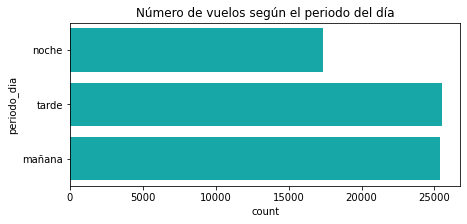

In [44]:
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="periodo_dia", data=df, color="c")
plt.title('Número de vuelos según el periodo del día')
plt.show()

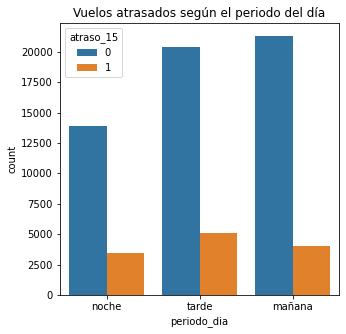

In [45]:
# Vuelos atrasados según periodo_dia
sns.countplot(x = 'periodo_dia', hue='atraso_15', data=df)
plt.title('Vuelos atrasados según el periodo del día')
plt.show()

In [46]:
analisis_atraso_por_col(df, 'periodo_dia')

,periodo_dia,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_periodo_dia,cumsum_total_vuelos,cumsum_atrasados
2,tarde,0.403203,0.373955,0.160066,0.373955,0.403203
0,mañana,0.321706,0.371698,0.200023,0.745653,0.724909
1,noche,0.275091,0.254347,0.199404,1.000000,1.000000


Hay aproximadamente la misma cantidad de vuelos  mañana y por la tarde, pero vemos considerablemente una menor cantidad de vuelos por la noche. 

El % de vuelos atrasados por periodo del día ronda el 19% para vuelos que son por la mañana y por la noche, y el 16% para vuelos que son por la tarde.
No se puede extraer ninguna conclusión de esto ya que consideramos que el % de vuelos atrasados por periodo del dia es parecido para la mañana, tarde y noche

##### OPERA

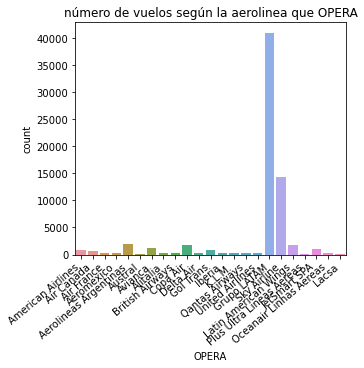

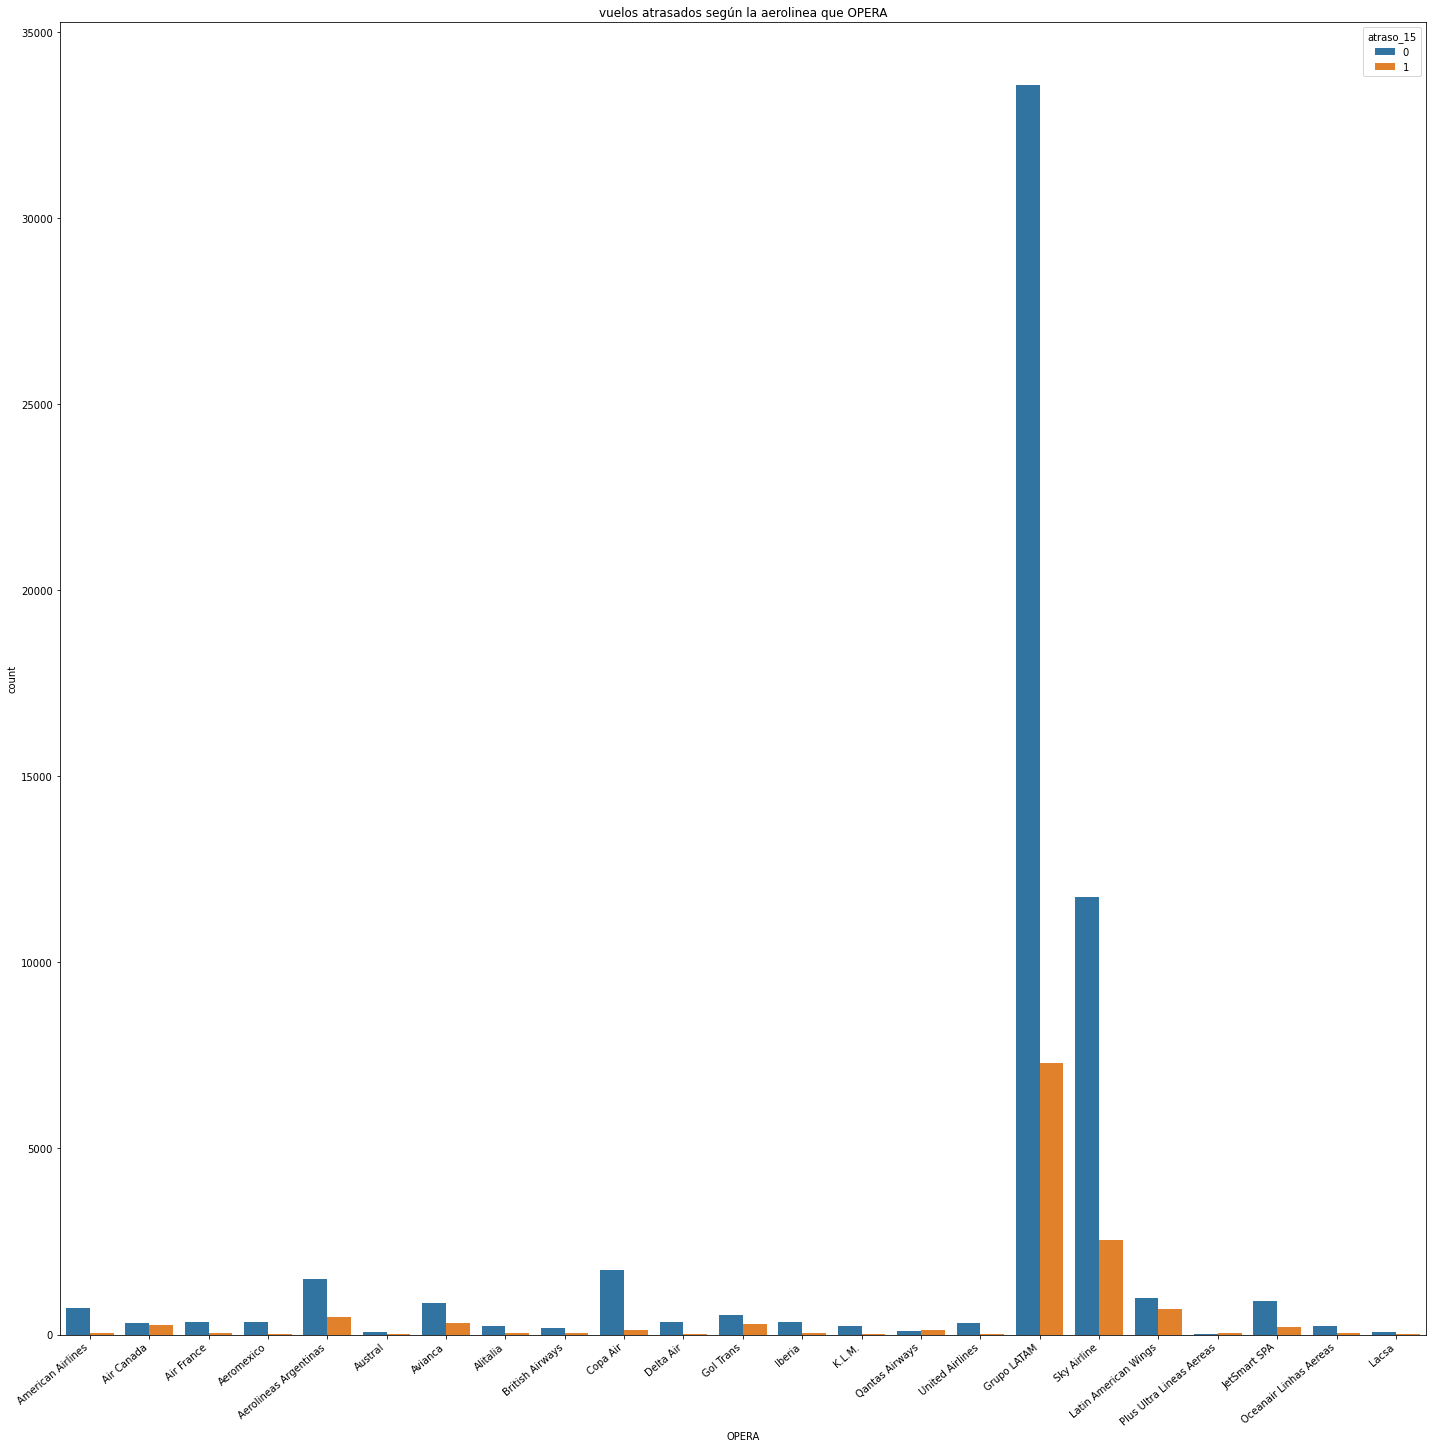

In [47]:
ax = sns.countplot(x = 'OPERA', data=df)
plt.rcParams["figure.figsize"] = (20, 20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 10)
plt.tight_layout()
plt.title('número de vuelos según la aerolinea que OPERA')
plt.show()

ax = sns.countplot(x = 'OPERA', hue='atraso_15', data=df)
plt.rcParams["figure.figsize"] = (20, 20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 10)
plt.tight_layout()
plt.title('vuelos atrasados según la aerolinea que OPERA')
plt.show()

In [48]:
analisis_atraso_por_col(df,'OPERA').head(10)

,OPERA,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_OPERA,cumsum_total_vuelos,cumsum_atrasados
12,Grupo LATAM,0.579198,0.599537,0.240123,0.599537,0.579198
21,Sky Airline,0.201364,0.209630,0.028490,0.809166,0.780561
0,Aerolineas Argentinas,0.037102,0.028575,0.456637,0.837742,0.817663
9,Copa Air,0.009196,0.027124,0.083799,0.864865,0.826859
17,Latin American Wings,0.053988,0.024543,0.111969,0.889409,0.880847
7,Avianca,0.024259,0.016890,0.067371,0.906299,0.905105
14,JetSmart SPA,0.015538,0.016054,0.202703,0.922353,0.920644
11,Gol Trans,0.022752,0.011817,0.265625,0.934170,0.943396
5,American Airlines,0.004043,0.011099,0.141463,0.945269,0.947439
2,Air Canada,0.020453,0.008284,0.062703,0.953552,0.967893


Las Aerolineas que mayor n° de vuelos operan son LATAM y Sky Airline (ambas representan un 81% del total de vuelos). Esto tiene sentido ya que son aerolineas locales de SCL - el origen de todos los vuelos del dataset. 
Después le siguen Aerolineas Argentinas, Copa Air, Latin American Wings, Avianca, Jetmar SPA, Gol Trans y American Airlines - representando en total casi un 95% de vuelos. 

Cabe resaltar que del total de vuelos atrasados, un 95% de los vuelos son llevados a cabo por estas mismas aerolineas. Estas son las aerolineas de mayor relevancia en nuestro caso. 

La columna 'OPERA' es una variable categórica, por lo que para incluir esto al modelo tenemos que agregarla como variables dummies. Para no agregar demasiadas variables al modelo y agregar ruido, vamos a incluir todas las aerolineas con menos vuelos (operados y atrasados) en una dummy que sea 'otro', para así dejar las aerolineas más importantes. 

##### Emp-I: código de aerolinea del vuelo programado

In [49]:
analisis_atraso_por_col(df,'Emp-I').head(10)

,Emp-I,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_Emp-I,cumsum_total_vuelos,cumsum_atrasados
17,LAN,0.511574,0.551432,0.067371,0.551432,0.511574
27,SKU,0.201364,0.209630,0.456637,0.761062,0.712938
28,TAM,0.061836,0.044703,0.083799,0.805765,0.774774
4,ARG,0.037102,0.028575,0.028490,0.834340,0.811876
9,CMP,0.009196,0.027124,0.240123,0.861464,0.821072
19,LAW,0.050896,0.023077,0.202703,0.884541,0.871968
6,AVA,0.024259,0.016890,0.265625,0.901431,0.896226
14,JAT,0.015538,0.016054,0.111969,0.917485,0.911765
12,GLO,0.022752,0.011817,0.141463,0.929302,0.934517
0,AAL,0.004043,0.011099,0.062703,0.940401,0.938560


Podemos ver que Emp-I y OPERA representan lo mismo - están altamente correlacionadas. Decidimos descartar 'Emp-I' 

Las diferencias entre Emp-I y OPERA se deben a que una aerolinea en OPERA puede incluir varios Emp-I (códigos de aerolinea): por ejemplo, Grupo LATAM incluye 'LAN', 'TAM', 'LAP', 'LXP', 'DSM', 'LPE', 'LNE'

In [50]:
dropcol(df, 'Emp-I')

##### Destino: SIGLADES y Des-O

Ambas variables se refieren al destino del vuelo. 

Des-O es el código de ciudad de destino del vuelo y SIGLADES es el nombre de la ciudad de destino. 


In [51]:
analisis_atraso_por_col(df,'Des-O').head(10)

,Des-O,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_Des-O,cumsum_total_vuelos,cumsum_atrasados
40,SCFA,0.067148,0.084831,0.314488,0.084831,0.067148
57,SPJC,0.096242,0.077266,0.141463,0.162097,0.163390
37,SCCF,0.049865,0.075448,0.000000,0.237545,0.213255
48,SCTE,0.058189,0.063880,0.058659,0.301425,0.271444
41,SCIE,0.049390,0.058543,0.070028,0.359968,0.320834
39,SCDA,0.050737,0.054937,0.000000,0.414905,0.371571
33,SBGR,0.069843,0.052327,0.050898,0.467232,0.441414
22,SAEZ,0.062867,0.047518,0.214660,0.514749,0.504281
20,SABE,0.065562,0.045363,0.251613,0.560112,0.569843
46,SCQP,0.031949,0.037959,0.264706,0.598071,0.601792


In [52]:
analisis_atraso_por_col(df,'SIGLADES').head(20)

,SIGLADES,%_atrasados_de_total_atrasados,%_de_total_vuelos,%_atrasados_por_SIGLADES,cumsum_total_vuelos,cumsum_atrasados
8,Buenos Aires,0.128429,0.092880,0.146388,0.092880,0.128429
0,Antofagasta,0.067148,0.084831,0.135468,0.177712,0.195576
28,Lima,0.096242,0.077266,0.284483,0.254978,0.291819
9,Calama,0.049865,0.075448,0.058659,0.330425,0.341684
42,Puerto Montt,0.058189,0.063880,0.373961,0.394305,0.399873
16,Concepcion,0.049390,0.058543,0.146603,0.452849,0.449263
24,Iquique,0.050737,0.054937,0.500000,0.507785,0.500000
54,Sao Paulo,0.069843,0.052327,0.258728,0.560112,0.569843
56,Temuco,0.031949,0.037959,0.255722,0.598071,0.601792
1,Arica,0.026161,0.035715,0.122231,0.633786,0.627953


In [53]:
DesOunique =df['Des-O'].nunique()
SIGLADESunique =df['SIGLADES'].nunique()
print(f'Des-O tiene {DesOunique} valores únicos y SIGLADES tiene {SIGLADESunique} valores únicos')

Des-O tiene 63 valores únicos y SIGLADES tiene 62 valores únicos


Decidimos descartar la variable 'Des-O' ya que ambas variables hablan sobre lo mismo y están altamente correlacionadas

In [54]:
dropcol(df,'Des-O')

#### Conclusiones

Los datos de las variables 'OPERA' y 'SIGLADES' están muy desbalanceados, ya que la mayoría de los datos se agrupan en unas pocas aerolineas y destinos. Para el resto de las variables, se podría decir que lo datos están balanceados. 

## Dummyfing or Labeling Categorical Variables

In [55]:
print('Las variables categóricas que hay en el dataset son:')
categorical = df.select_dtypes(include=['category', 'object']).columns.to_list()
print(categorical)

Las variables categóricas que hay en el dataset son:
['DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'periodo_dia']


Además, la variable MES está puesta como variable numérica pero en realidad es una variable categórica. 

In [56]:
enc_dict_MES = {1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre',
}
df['MES'] = df['MES'].map(enc_dict_MES)  

In [57]:
categorical = df.select_dtypes(include=['category', 'object']).columns.to_list()
print(categorical)

['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'periodo_dia']


Para incluir las variables categóricas al modelo, hay que dummificarlas o hacer label encoder. 

Cuando la variable categórica sea ordinal, vamos a usar LabelEncoder. Por el contrario usaremos OneHotEncoding. Esto lo que hace es aumentar considerablemente el número de columnas del dataset, metiendo más 'ruido' al modelo.

Vamos a observar primero cuantos valores únicos hay por cada variable categórica. 

<AxesSubplot:>

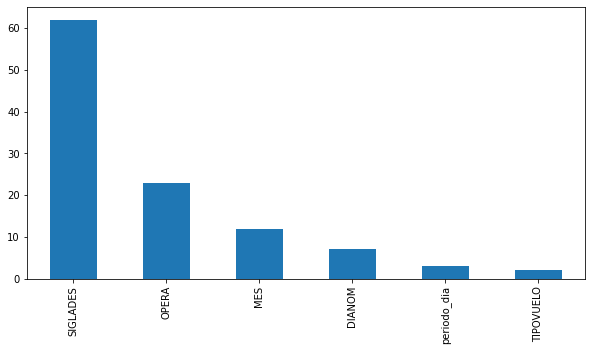

In [58]:
df[categorical].nunique().sort_values(ascending=False).plot.bar(figsize=(10,5))

Para la variable 'TIPOVUELO' hay solamente 2 valores - N o I. 

Vamos a hacer una sola columna: TIPOVUELO_N donde es 0 si el vuelo es Internacional, y 1 si es Nacional. 
LabelEncoder de sklearn, nos va a hacer el encoder según el orden en el que aparecen los datos. El primer dato que hay es de un vuelo internacional, con lo que TIPOVUELO_N será igual a 0. 

In [59]:
le = preprocessing.LabelEncoder()
df['TIPOVUELO_I'] = le.fit_transform(df['TIPOVUELO'])
dropcol(df, 'TIPOVUELO')

Analizar variables ordinales: 

In [60]:
df.columns

Index(['MES', 'DIANOM', 'OPERA', 'SIGLADES', 'dif_min', 'atraso_15',
       'temporada_alta', 'periodo_dia', 'cambio_aerolinea', 'cambio_num_vuelo',
       'same_destination', 'TIPOVUELO_I'],
      dtype='object')

In [61]:
df.head(5)

,MES,DIANOM,OPERA,SIGLADES,dif_min,atraso_15,temporada_alta,periodo_dia,cambio_aerolinea,cambio_num_vuelo,same_destination,TIPOVUELO_I
0,Enero,Domingo,American Airlines,Miami,3.0,0,0,noche,0,0,1,0
1,Enero,Lunes,American Airlines,Miami,9.0,0,0,noche,0,0,1,0
2,Enero,Martes,American Airlines,Miami,9.0,0,0,noche,0,0,1,0
3,Enero,Miercoles,American Airlines,Miami,3.0,0,0,noche,0,0,1,0
4,Enero,Jueves,American Airlines,Miami,-2.0,0,0,noche,0,0,1,0


In [62]:
ordinal = ['periodo_dia'] 
categorical = ['OPERA','SIGLADES', 'DIANOM', 'MES']

Para las columnas ordinales, vamos a usar Label Encoder. En este caso vamos a "forzar" el encoder para ponerlo en el orden que tiene sentido.

In [63]:
# columna periodo_dia
enc_dict_periododia = {'mañana':0,
            'tarde':1,
            'noche':2}
df['periodo_dia'] = df['periodo_dia'].map(enc_dict_periododia)  

Para la variable 'OPERA' vimos que Las Aerolineas LATAM, Sky Airline, Aerolineas Argentinas, Copa Air, Latin American Wings, Avianca, JetSmart SPA, Gol Trans y American Airlines representan un 95% de los vuelos. 

Para no crear una dummy column por cada variable que hay en 'OPERA' y meter más ruido al modelo, vamos a crear una columna dummy por cada aerolinea que sea main_airline, y el resto de aerolineas las vamos a incluir en otra columna dummy que sea 'Other'

In [64]:
main_airlines = ['Grupo LATAM', 'Sky Airline', 'Aerolineas Argentinas', 'Copa Air', 'Latin American Wings', 'Avianca', 'JetSmart SPA', 'Gol Trans', 'American Airlines']

df.loc[~df["OPERA"].isin(main_airlines), 'OPERA'] = "Other"

In [65]:
df['OPERA'].value_counts()

Grupo LATAM              40892
Sky Airline              14298
Other                     3733
Aerolineas Argentinas     1949
Copa Air                  1850
Latin American Wings      1674
Avianca                   1152
JetSmart SPA              1095
Gol Trans                  806
American Airlines          757
Name: OPERA, dtype: int64

Después de esta transformación, vamos a crear variables dummies para la columna 'OPERA', 'DIANOM' y 'MES'

In [66]:
df = DummyCol(df,['OPERA', 'DIANOM', 'MES'])

In [67]:
df.columns

Index(['SIGLADES', 'dif_min', 'atraso_15', 'temporada_alta', 'periodo_dia',
       'cambio_aerolinea', 'cambio_num_vuelo', 'same_destination',
       'TIPOVUELO_I', 'OPERA_Aerolineas Argentinas', 'OPERA_American Airlines',
       'OPERA_Avianca', 'OPERA_Copa Air', 'OPERA_Gol Trans',
       'OPERA_Grupo LATAM', 'OPERA_JetSmart SPA', 'OPERA_Latin American Wings',
       'OPERA_Other', 'OPERA_Sky Airline', 'DIANOM_Domingo', 'DIANOM_Jueves',
       'DIANOM_Lunes', 'DIANOM_Martes', 'DIANOM_Miercoles', 'DIANOM_Sabado',
       'DIANOM_Viernes', 'MES_Abril', 'MES_Agosto', 'MES_Diciembre',
       'MES_Enero', 'MES_Febrero', 'MES_Julio', 'MES_Junio', 'MES_Marzo',
       'MES_Mayo', 'MES_Noviembre', 'MES_Octubre', 'MES_Septiembre'],
      dtype='object')

In [68]:
atraso_siglades = analisis_atraso_por_col(df,'SIGLADES')
print(f'El total de destinos SIGLADES es de: {len(atraso_siglades)}')

# Sacamos la lista de destinos que tienen el 95% de los vuelos. 
main_SIGLADES = atraso_siglades.loc[(atraso_siglades['cumsum_total_vuelos'] < 0.95)]['SIGLADES'].unique().tolist()

print(f'Los destinos principales son : {main_SIGLADES}')

print(f'El total de destino principales es de: {len(main_SIGLADES)}')

El total de destinos SIGLADES es de: 62
Los destinos principales son : ['Buenos Aires', 'Antofagasta', 'Lima', 'Calama', 'Puerto Montt', 'Concepcion', 'Iquique', 'Sao Paulo', 'Temuco', 'Arica', 'La Serena', 'Punta Arenas', 'Ciudad de Panama', 'Copiapo', 'Mendoza', 'Bogota', 'Rio de Janeiro', 'Montevideo', 'Cordoba', 'Miami', 'Madrid', 'Balmaceda', 'Valdivia', 'Ciudad de Mexico', 'Isla de Pascua', 'Guayaquil', 'Nueva York', 'Auckland N.Z.', 'Paris', 'Atlanta']
El total de destino principales es de: 30


In [69]:
df.loc[~df["SIGLADES"].isin(main_SIGLADES), 'SIGLADES'] = "Other"

In [70]:
df['SIGLADES'].value_counts()

Buenos Aires        6335
Antofagasta         5786
Lima                5270
Calama              5146
Puerto Montt        4357
Concepcion          3993
Iquique             3747
Sao Paulo           3569
Other               3544
Temuco              2589
Arica               2436
La Serena           2410
Punta Arenas        2105
Ciudad de Panama    1850
Copiapo             1780
Mendoza             1625
Bogota              1604
Rio de Janeiro      1435
Montevideo          1066
Cordoba             1023
Miami               1016
Madrid               894
Balmaceda            839
Valdivia             753
Ciudad de Mexico     700
Isla de Pascua       452
Guayaquil            422
Nueva York           382
Auckland N.Z.        361
Paris                359
Atlanta              358
Name: SIGLADES, dtype: int64

Con este filtro, lo que conseguimos es disminuir en más de un 50% el número de columnas Dummies. 
Nos hemos quedado con los destinos que representan un total del 95% de vuelos y de 95% de vuelos atrasados. 

In [71]:
# creamos las columnas dummies
df = DummyCol(df,['SIGLADES'])

In [72]:
df.head()

,dif_min,atraso_15,temporada_alta,periodo_dia,cambio_aerolinea,cambio_num_vuelo,same_destination,TIPOVUELO_I,OPERA_Aerolineas Argentinas,OPERA_American Airlines,...,SIGLADES_Montevideo,SIGLADES_Nueva York,SIGLADES_Other,SIGLADES_Paris,SIGLADES_Puerto Montt,SIGLADES_Punta Arenas,SIGLADES_Rio de Janeiro,SIGLADES_Sao Paulo,SIGLADES_Temuco,SIGLADES_Valdivia
0,3.0,0,0,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,9.0,0,0,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,9.0,0,0,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3.0,0,0,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,-2.0,0,0,2,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Missing Values   

In [73]:
df.isnull().sum()

dif_min                    0
atraso_15                  0
temporada_alta             0
periodo_dia                0
cambio_aerolinea           0
                          ..
SIGLADES_Punta Arenas      0
SIGLADES_Rio de Janeiro    0
SIGLADES_Sao Paulo         0
SIGLADES_Temuco            0
SIGLADES_Valdivia          0
Length: 68, dtype: int64

No tenemos missing values.

## Dataset final 

In [74]:
custom_df = df.copy()
custom_df.to_csv("Challenge_LATAM/custom_df.csv")